In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import re
from scipy import stats
import shap
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D  
from datetime import timedelta

Make sure to read in raw data, before pre-processing. Code requires only numerical data frames with no NaN values. Code also assumes features have the same names as found in the appendix of the "ICER_Final_Report.docx" appendix for SLURM data, Due to pre-processing package "datetime", data must be read in via pandas

Example of loading data.

df = pd.read_csv("DID_FINAL_SLURM_OCT_2023_aggregated.csv")

In [3]:
#Pre-Processing with Shams Code
slurm=df
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])
slurm['End'] = pd.to_datetime(slurm['Start'])

In [4]:
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if isinstance(mem_str, (int, float, complex)):   # if its a numeric type zero
        return float(mem_str)
    elif mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    else:
        return float(mem_str)    # when its a string zero '0'
    
# First drop rows with NA requested memory
slurm= slurm.dropna(subset=['ReqMem'])
slurm= slurm.dropna(subset=['MaxRSS'])


slurm['ReqMem_MB'] = slurm['ReqMem'].apply(convert_memory)
slurm['MaxRSS_MB'] = slurm['MaxRSS'].apply(convert_memory)

# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm['Timelimit_'] = slurm['Timelimit'].apply(parse_time_string)
slurm['total_minutes'] = slurm['Elapsed'].apply(parse_time_string)
# C
slurm['total_minutes'] = pd.to_timedelta(slurm['total_minutes']).dt.total_seconds() / 60 
slurm['Timelimit_'] = pd.to_timedelta(slurm['Timelimit_']).dt.total_seconds() / 60  

df=slurm

df.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,Timelimit_,total_minutes
201,201,87461884,user_600,group_090,2023-09-08 18:34:09,2023-09-29 21:30:06,2023-09-29 21:30:06,1-08:12:31,COMPLETED,account_011,...,4500K,4,4,"lac-[084-086,193]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.500,2160.0,1932.516667
202,202,87461892,user_600,group_090,2023-09-08 18:34:11,2023-09-30 00:16:32,2023-09-30 00:16:32,1-06:03:08,COMPLETED,account_011,...,4540K,4,4,"lac-[142,192,345,349]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,2160.0,1803.133333
203,203,87461900,user_600,group_090,2023-09-08 18:34:13,2023-09-30 01:07:56,2023-09-30 01:07:56,1-05:26:01,COMPLETED,account_011,...,4536K,4,4,"lac-[080-081,342-343]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.536,2160.0,1766.016667
204,204,87461908,user_600,group_090,2023-09-08 18:34:15,2023-09-30 03:06:56,2023-09-30 03:06:56,1-06:09:06,COMPLETED,account_011,...,4540K,4,4,"lac-[031,136,346-347]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,2160.0,1809.100000
205,205,87461916,user_600,group_090,2023-09-08 18:34:18,2023-09-30 08:13:45,2023-09-30 08:13:45,1-06:16:43,COMPLETED,account_011,...,4604K,4,4,"lac-[083,196,344,348]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.604,2160.0,1816.716667


In [5]:
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB','MaxRSS_MB' ]


After pre-processing the data, using the same code from the DataAnalyzer.py file, we make sorted bar graphs showing job resource utilization by "Group" in SLURM data

In [14]:
unique_values = df['Group'].unique()
print("Unique values in 'Group' column:", len(unique_values))

Unique values in 'Group' column: 149


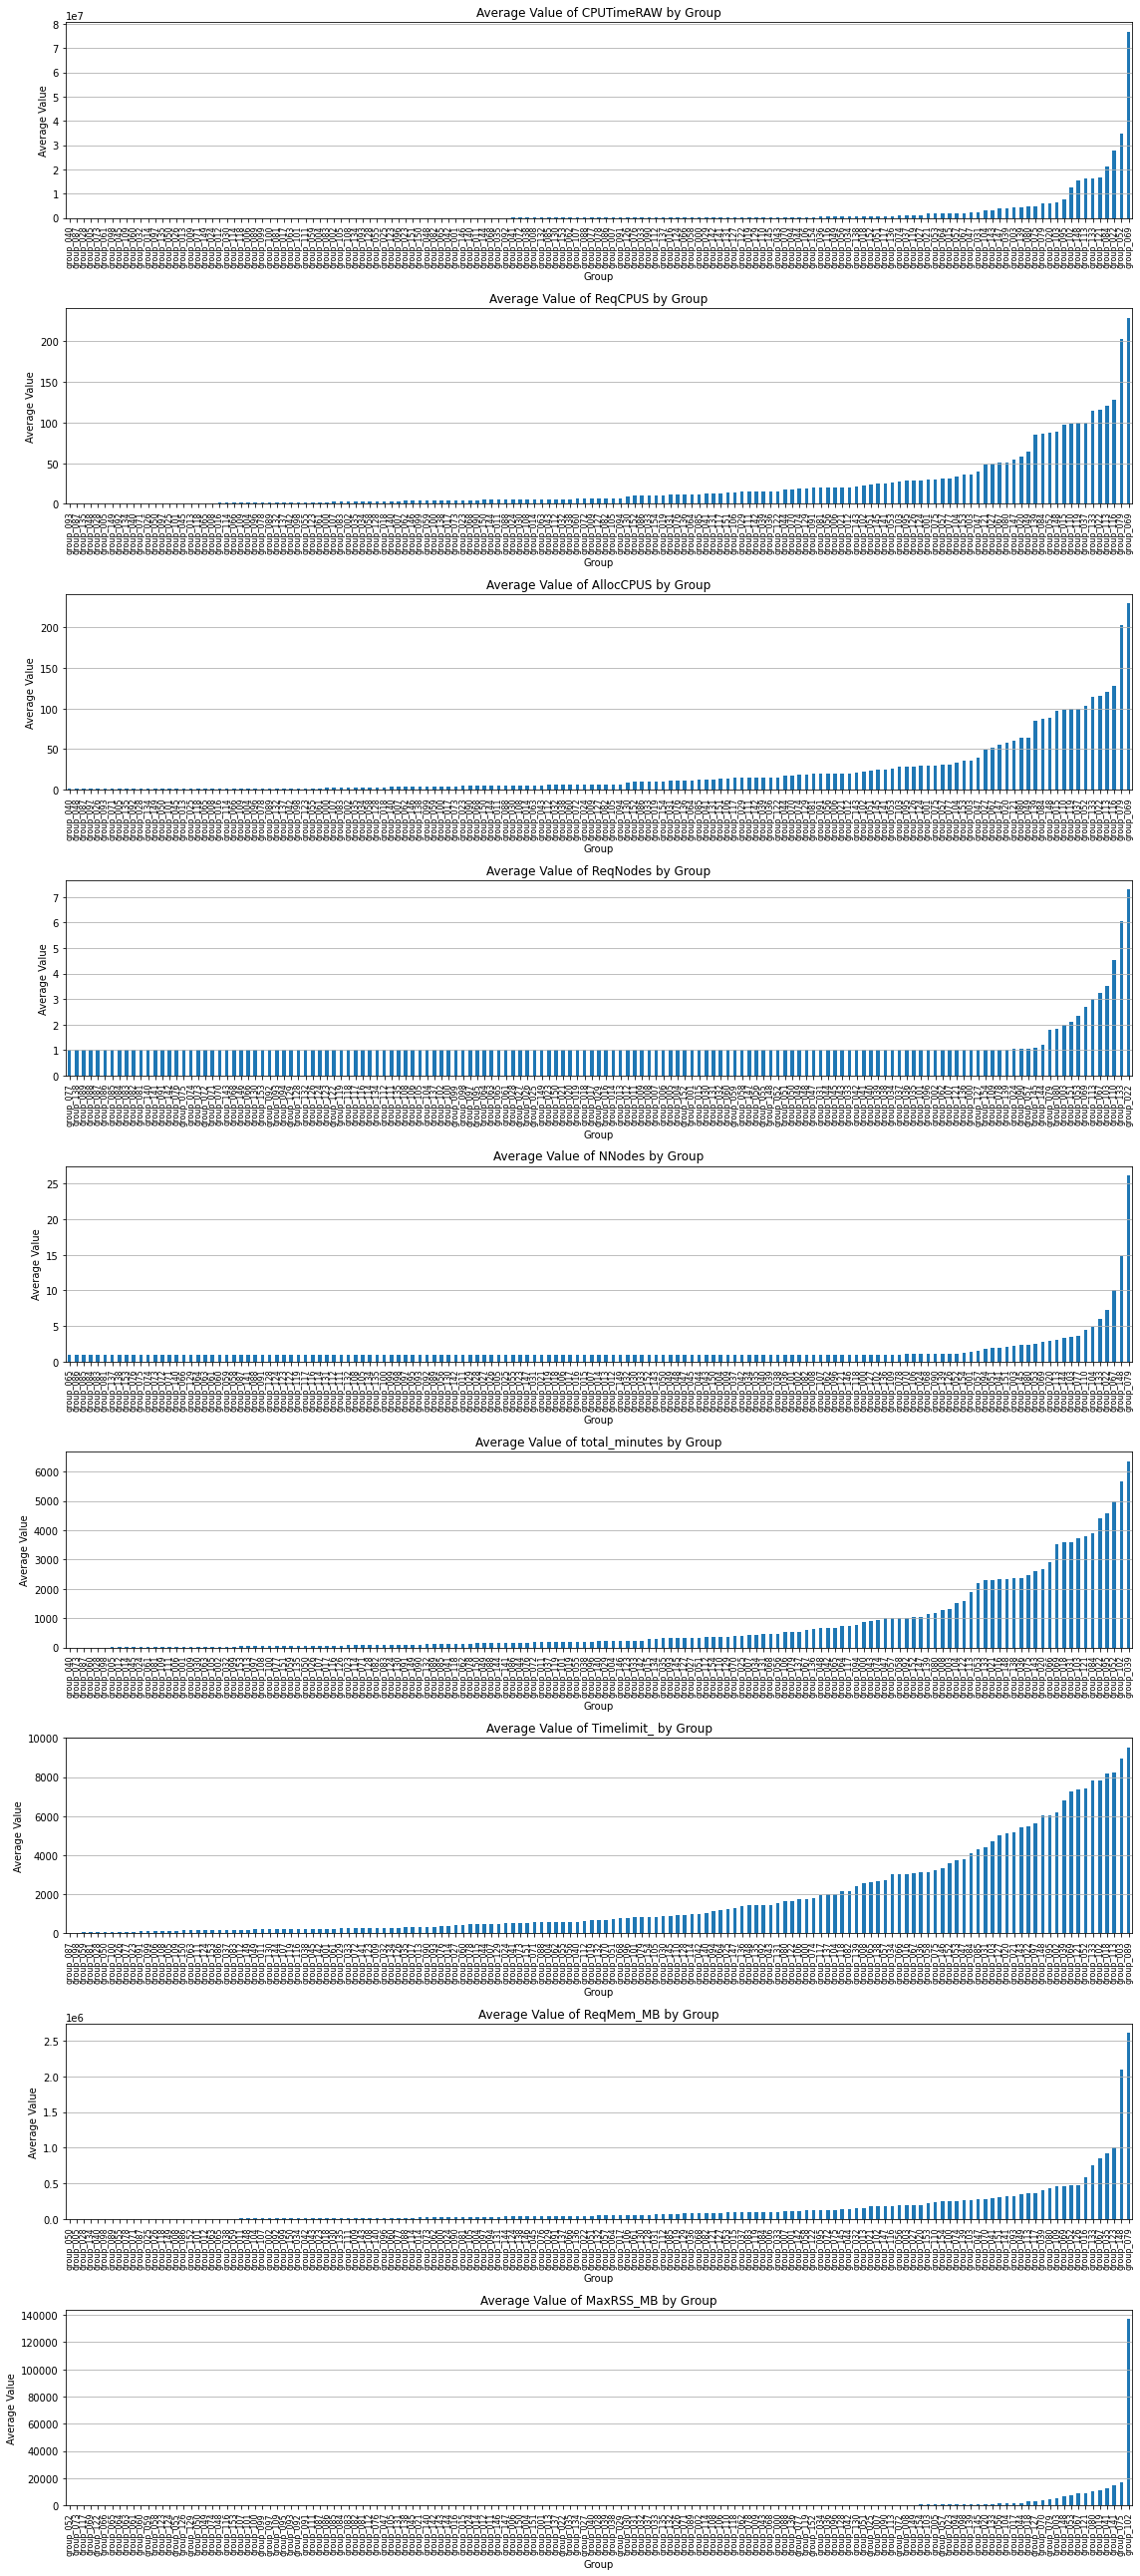

In [6]:
num_features = len(features3)
fig, axs = plt.subplots(num_features, 1, figsize=(16, 4*num_features))

for i, feature in enumerate(features3):
    average_by_group = df.groupby('Group')[feature].mean()
    average_by_group_sorted = average_by_group.sort_values()
    
    ax = axs[i]
    average_by_group_sorted.plot(kind='bar', ax=ax)
    ax.set_title(f'Average Value of {feature} by Group')
    ax.set_xlabel('Group')
    ax.set_ylabel('Average Value')
    ax.grid(axis='y')  
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.savefig('plot.pdf', format='pdf', dpi=200)
plt.tight_layout()
plt.show()

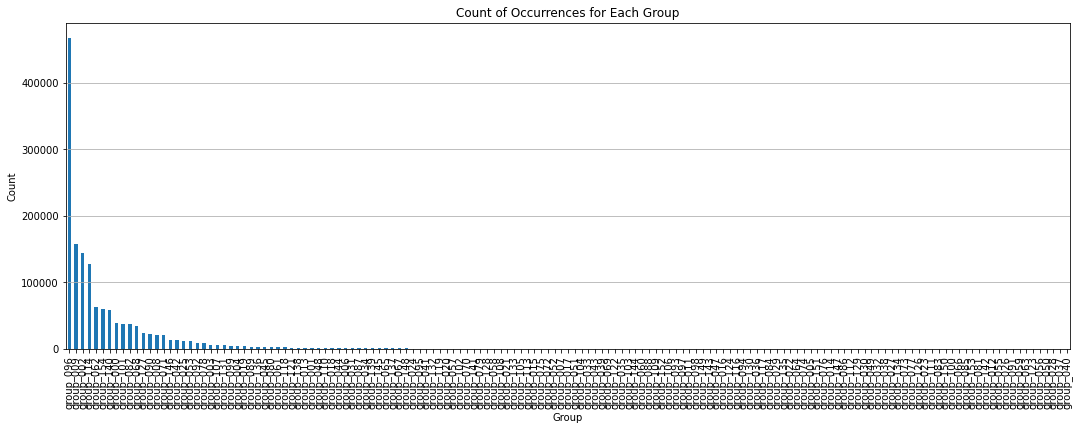

In [7]:
group_counts = df['Group'].value_counts()
plt.figure(figsize=(18, 6))
group_counts.plot(kind='bar')
plt.title('Count of Occurrences for Each Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.grid(axis='y')  
ax.set_xticklabels(ax.get_xticklabels(), fontsize=3)
plt.show()

Here, we generate CDFs of each of the numeric features in the SLURM data frame, after pre-processing

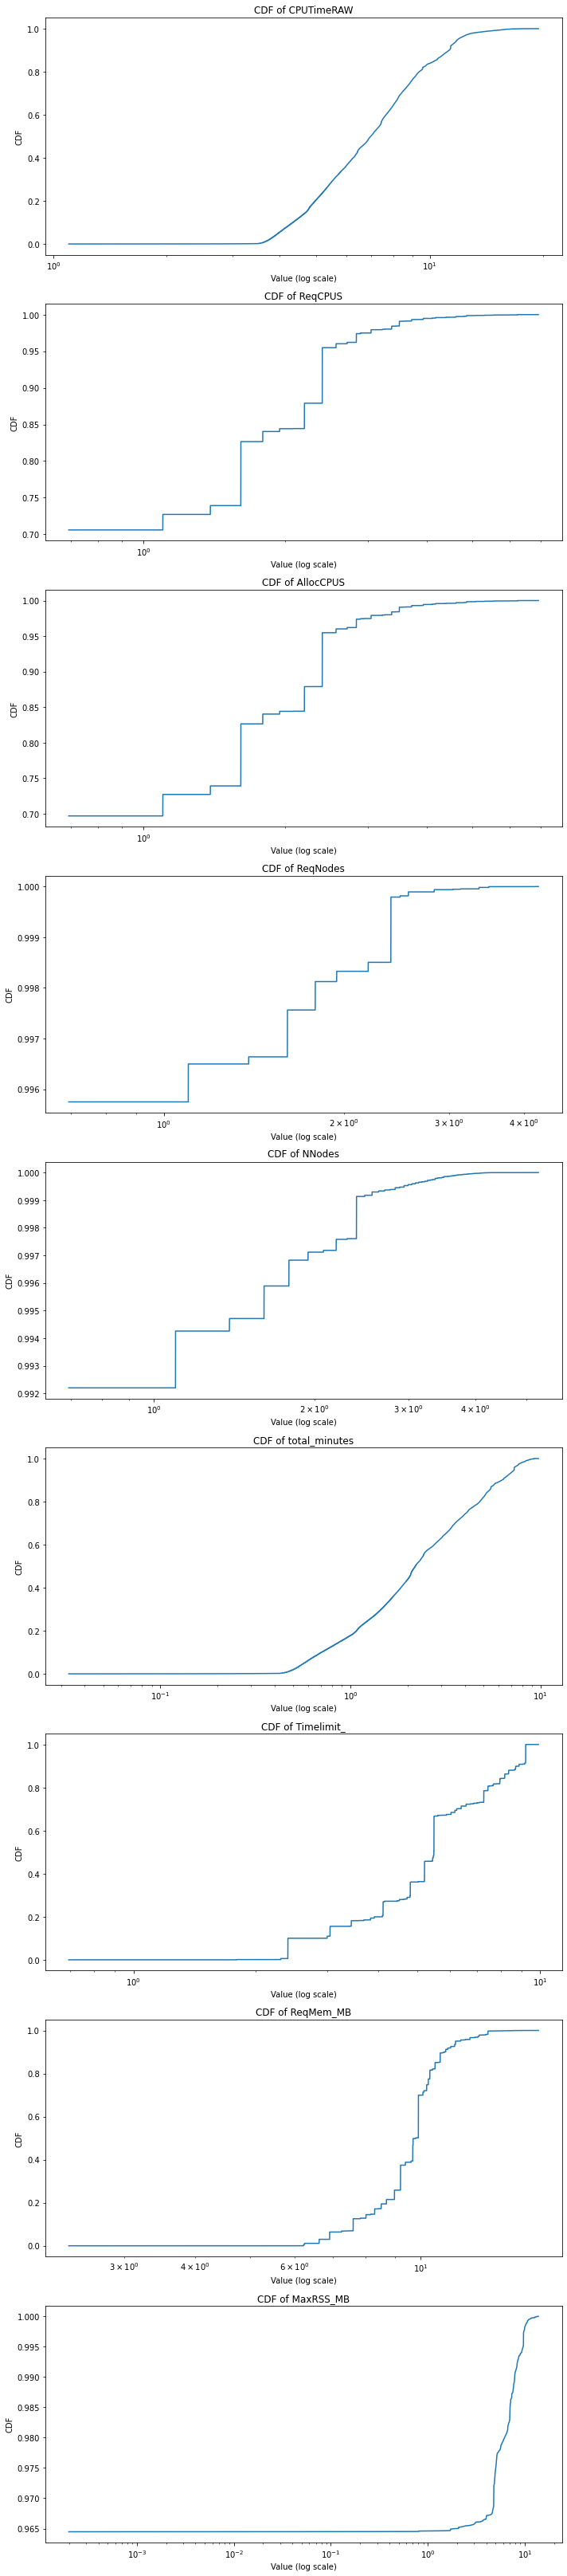

In [11]:
fig, axs = plt.subplots(len(features3), 1, figsize=(10, 5 * len(features3)))

for i, feature in enumerate(features3):
    data = np.log1p(df[feature])
    counts, bin_edges = np.histogram(data, bins=70000, density=True)
    cdf = np.cumsum(counts) * np.diff(bin_edges)
    
    axs[i].plot(bin_edges[1:], cdf)
    axs[i].set_xscale('log')
    axs[i].set_title(f'CDF of {feature}')
    axs[i].set_xlabel('Value (log scale)')
    axs[i].set_ylabel('CDF')

plt.tight_layout()
plt.show()